# Implement names generator

Use architecture described in "WaveNet ..." by DeepMind

In [ ]:
import time
import random

import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# plt.style.use('classic')
plt.style.use('dark_background')

In [ ]:
torch.cuda.is_available()

In [4]:
def move_to_device(tensors, device):
    new_tensors = [None] * len(tensors)
    with torch.no_grad():
        for idx, tensor in enumerate(tensors):
            new_tensors[idx] = tensor.to(device, copy=True)
    return new_tensors

### Prepare dataset

In [5]:
with open('names.txt', 'r') as f:
    random.seed(345)
    words = f.read().splitlines()
    random.shuffle(words)


In [6]:
block_size = 10

In [7]:
all_letters = set(sum((list(s) for s in words), []))

In [8]:
all_symbols = all_letters.union({'.'})
stoi = {'.': 0}
stoi.update({letter: idx for idx, letter in enumerate(all_letters, 1)})
itos = {idx: letter for letter, idx in stoi.items()}

# create dataset
X = list()
y = list()
for word in words:
    word = block_size * '.' + word + '.'
    for idx in range(block_size, len(word)):
        prev = word[(idx-block_size):idx]
        X.append(list(stoi[s] for s in prev))
        y.append(stoi[word[idx]])

X = torch.tensor(X)
y = torch.tensor(y)

In [9]:
def split_dataset(X, y):
    total_len = X.shape[0]
    
    n1 = int(0.8 * total_len)
    n2 = int(0.9 * total_len)

    return (X[:n1], y[:n1]), (X[n1:n2], y[n1:n2]), (X[n2:], y[n2:])

    # num_tr = round(0.6 * total_len)
    # num_val = round(0.2 * total_len)
    # num_test = total_len - num_tr - num_val
    # idx_tr, idx_val, idx_test = torch.utils.data.random_split(range(X.shape[0]), [num_tr, num_val, num_test])
    # return (X[idx_tr], y[idx_tr]), (X[idx_val], y[idx_val]), (X[idx_test], y[idx_test])

In [10]:
(Xtr, ytr), (Xval, yval), (Xtest, ytest) = split_dataset(X, y)

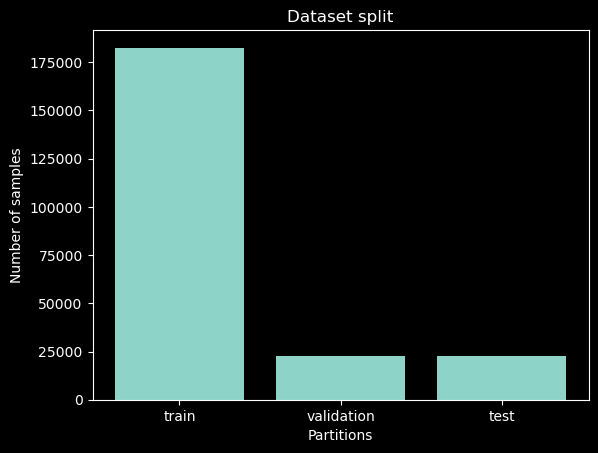

In [11]:
_, ax = plt.subplots(1, 1)
ax.set_title("Dataset split")
ax.set_xlabel("Partitions")
ax.set_ylabel("Number of samples")
ax.bar(['train', 'validation', 'test'], [len(Xtr), len(Xval), len(Xtest)])
plt.show()

### Define model class, loss and training loop

In [12]:
class Introspector:
    def __init__(self):
        self.first_layer_volume = None
        self.second_layer_activations = None
        self.third_layer_activations = None
        
        self.update_to_data_ratios = {}

In [45]:
class Embedding:
    def __init__(self, vocab_size, embedding_len):
        self.embedding_matr = torch.randn((vocab_size, embedding_len))

    def __call__(self, X):
        return self.embedding_matr[X]
    
    def parameters(self):
        return [self.embedding_matr]

class Flatten:
    def __call__(self, X):
        return X.view(X.shape[0], -1)
    def parameters(self):
        return []

class Linear:
    def __init__(self, prev_num_nodes, num_nodes):
        self.biases = torch.ones((num_nodes,)) * 0.0001
        self.weights = torch.randn(prev_num_nodes, num_nodes) / np.sqrt(prev_num_nodes)
    def __call__(self, X):
        out = (X @ self.weights) + self.biases
        return out
    def parameters(self):
        return [self.biases, self.weights]

class FuseConsecutive:
    def __call__(self, X):
        B, T, C = X.shape
        assert T % 2 == 0
        if T == 2:
            return X.view(B, C * 2)
        else:
            return X.view(B, T // 2, C * 2)
    def parameters(self):
        return []

class Tanh:
    def __call__(self, X):
        return torch.tanh(X)
    def parameters(self):
        return []

class BatchNorm1D:
    def __init__(self, num_nodes):
        # Initialize parameters
        self.gain = torch.ones(num_nodes)
        self.bias = torch.zeros(num_nodes)
        # Initialize buffers
        self.running_mean = torch.zeros((1, num_nodes))
        self.running_var = torch.ones((1, num_nodes))
        # Other
        self.training = True
        self.momentum = 0.1
    def __call__(self, X):
        if self.training:
            batch_mean = X.mean(axis=(0, 1), keepdim=True)
            batch_var = X.var(axis=(0, 1), keepdim=True)
            
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            
            normalized_X = (X - batch_mean) / (torch.sqrt(batch_var) + 1e-6)

            return self.gain * normalized_X + self.bias
        else:
            normalized_X = (X - self.running_mean) / (np.sqrt(self.running_var) + 1e-6)
            return self.gain * normalized_X + self.bias
    def parameters(self):
        return [self.bias, self.gain]


In [46]:
class Model:
    def __init__(self):
        # HPs
        self.embeddings_len = 15
        self.hidden_nodes1 = 100

        # Initialize layers
        self.layers = [
            Embedding(len(all_symbols), self.embeddings_len),
            FuseConsecutive(),
            Linear(2 * self.embeddings_len, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1),
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, len(all_symbols))
        ]
        
        self.layers[2].weights *= 5 / 3
        self.layers[6].weights *= 5 / 3
        self.layers[-1].weights *= 0.01
        
        for layer in self.layers:
            for parameter in layer.parameters():
                parameter.requires_grad = True

        # Other
        self.introspector = Introspector()
        self.training = True

    def create_preds(self, X):
        for layer in self.layers:
            layer.training = self.training
        # self.layers[3].training = self.training
        
        for layer in self.layers:
            X = layer(X)
            # print(f"{layer.__class__.__name__}: {X}")
            # if X.isnan().any():
            #     return

        # self.introspector.second_layer_activations = X.clone()

        # for layer in self.layers[5:]:
            # X = layer(X)

        probs = torch.softmax(X, 1)

        self.introspector.third_layer_activations = probs.clone()

        return probs

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def move_to_device(self, device):
        parameters = move_to_device(self.parameters(), device)
        for p in parameters:
            p.requires_grad = True
        self.C, self.biases1, self.weights1, self.biases2, self.weights2 = parameters


In [47]:
def create_loss(predictions, actual):
    return - predictions[range(len(predictions)), actual].log().mean()


In [49]:
def training_loop(model: Model, num_iters, batch_size, lr):
    start_ts = time.time()
    
    print(f"Iter #0", )
    with torch.no_grad():
        train_loss = create_loss(model.create_preds(Xtr), ytr).item()
        val_loss = create_loss(model.create_preds(Xval), yval).item()
    print(f"\ttrain_loss = {train_loss:.2f}")
    print(f"\tval_loss = {val_loss:.2f}\n")

    for num_iter in range(num_iters):
        # get batch
        indices = torch.randint(0, len(Xtr) - 1, (batch_size,))
        batch_X = Xtr[indices]
        batch_y = ytr[indices]
        # batch_X = Xtr
        # batch_y = ytr
        
        # calculate loss
        loss = create_loss(model.create_preds(batch_X), batch_y)
        reg_loss = 0
        num_terms = 0
        for layer in model.layers:
            if isinstance(layer, Linear):
                reg_loss = reg_loss + torch.sum(torch.square(layer.weights))
                num_terms += layer.weights.nelement()
        loss = loss + 5 * reg_loss / num_terms

        # zerograd
        for parameter_tensor in model.parameters():
            parameter_tensor.grad = None

        # backprop
        loss.backward()

        # update weights
        ratios = model.introspector.update_to_data_ratios
        for param_idx, parameter_tensor in enumerate(model.parameters()):
            if parameter_tensor.ndim == 2:
                ratio = (lr * parameter_tensor.grad).std() / parameter_tensor.data.std()
                if param_idx in ratios:
                    ratios[param_idx].append(ratio)
                else:
                    ratios[param_idx] = [ratio]
            if parameter_tensor.grad.isnan().any():
                print(f"Gradient {param_idx} is None")
                return
            parameter_tensor.data -= lr * parameter_tensor.grad

        # display train and validation losses
        if ((num_iter + 1) % 10_000) == 0:
            print(f"Iter #{num_iter+1}", )
            model.training = False
            with torch.no_grad():
                train_loss = create_loss(model.create_preds(Xtr), ytr).item()
                val_loss = create_loss(model.create_preds(Xval), yval).item()
            model.training = True
            print(f"\ttrain_loss = {train_loss:.2f}")
            print(f"\tval_loss = {val_loss:.2f}\n")

        # if time.time() - start_ts >= max_time:
        #     break


### Train the model

In [50]:
# Create model
model = Model()

# Move to device
# device = torch.device('cuda', 0)
device = torch.device('cpu')
# model.move_to_device(device)
# Xtr, ytr, Xval, yval = move_to_device(
#     [
#         Xtr, ytr, Xval, yval
#     ],
#     device
# )

In [51]:
model.training = True
batch_size = 32

lr = 0.05
print(f"lr = {lr}")
training_loop(model, 100_000, batch_size, lr)

lr = 0.01
print(f"lr = {lr}")
training_loop(model, 50_000, batch_size, lr)

lr = 0.001
print(f"lr = {lr}")
training_loop(model, 40_000, batch_size, lr)

lr = 0.0001
print(f"lr = {lr}")
training_loop(model, 20_000, batch_size, lr)


lr = 0.05
Iter #0
	train_loss = 3.30
	val_loss = 3.30

Iter #10000
	train_loss = 2.13
	val_loss = 2.18

Iter #20000
	train_loss = 2.07
	val_loss = 2.14

Iter #30000
	train_loss = 2.03
	val_loss = 2.12

Iter #40000
	train_loss = 2.01
	val_loss = 2.10

Iter #50000
	train_loss = 2.00
	val_loss = 2.10

Iter #60000
	train_loss = 1.99
	val_loss = 2.10

Iter #70000
	train_loss = 1.97
	val_loss = 2.09

Iter #80000
	train_loss = 1.97
	val_loss = 2.09

Iter #90000
	train_loss = 1.97
	val_loss = 2.09

Iter #100000
	train_loss = 1.95
	val_loss = 2.08

lr = 0.01
Iter #0
	train_loss = 1.94
	val_loss = 2.08

Iter #10000
	train_loss = 1.87
	val_loss = 2.03

Iter #20000
	train_loss = 1.86
	val_loss = 2.03

Iter #30000
	train_loss = 1.85
	val_loss = 2.03

Iter #40000
	train_loss = 1.85
	val_loss = 2.03

Iter #50000
	train_loss = 1.85
	val_loss = 2.03

lr = 0.001
Iter #0
	train_loss = 1.84
	val_loss = 2.03

Iter #10000
	train_loss = 1.83
	val_loss = 2.02

Iter #20000
	train_loss = 1.82
	val_loss = 2.02



In [53]:
model.training = False
with torch.no_grad():
    train_loss = create_loss(model.create_preds(Xtr), ytr)
    val_loss = create_loss(model.create_preds(Xval), yval)
    test_loss = create_loss(model.create_preds(Xtest), ytest)
print(f"Training loss: {train_loss.item():.2f}")
print(f"Validation loss: {val_loss.item():.2f}")
print(f"Test loss: {test_loss.item():.2f}")

Training loss: 1.82
Validation loss: 2.02
Test loss: 1.98


1. Model 1
- code
```python
# Batch norm is broken
block_size=4
embedding_len = 15
hidden_nodes=400
Embedding(len(all_symbols), self.embeddings_len),
FuseConsecutive(),
Linear(2 * self.embeddings_len, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), Tanh(),
FuseConsecutive(),
Linear(2 * self.hidden_nodes1, len(all_symbols))
```
- metrics:
```
train_loss = 2.08
val_loss = 2.13
```

2. Model 2
- code
```python
block_size=8
        # HPs
        self.embeddings_len = 15
        self.hidden_nodes1 = 100

        # Initialize layers
        self.layers = [
            Embedding(len(all_symbols), self.embeddings_len),
            FuseConsecutive(),
            Linear(2 * self.embeddings_len, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, len(all_symbols))
        ]
```
- metrics:
```
train_loss = 1.86
val_loss = 2.03
```

3. Model 3
- code
```python
block_size=16
        # HPs
        self.embeddings_len = 15
        self.hidden_nodes1 = 100

        # Initialize layers
        self.layers = [
            Embedding(len(all_symbols), self.embeddings_len),
            FuseConsecutive(),
            Linear(2 * self.embeddings_len, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1),
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, len(all_symbols))
        ]
```
- metrics:
```
train_loss = 1.81
val_loss = 2.02
```
4. Model 4
- code
```python
block_size=16
        # HPs
        self.embeddings_len = 15
        self.hidden_nodes1 = 200

        # Initialize layers
        self.layers = [
            Embedding(len(all_symbols), self.embeddings_len),
            FuseConsecutive(),
            Linear(2 * self.embeddings_len, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), 
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1),
            Tanh(),
            FuseConsecutive(),
            Linear(2 * self.hidden_nodes1, len(all_symbols))
        ]
```
- metrics
```
train_loss = 1.67
val_loss = 2.02
```
5. Same as model 3, but with L2 regularization (lambda = 1)
- metrics
```
train_loss = 1.82
val_loss = 2.02
```


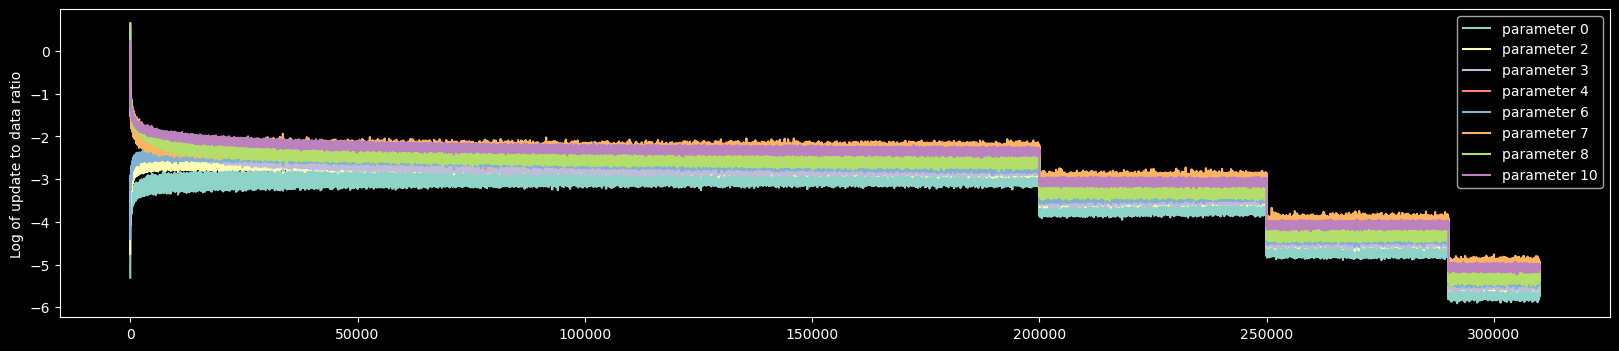

In [19]:
ratios = model.introspector.update_to_data_ratios

plt.figure(figsize=(20, 4))
for param_idx in ratios:
    plt.plot([np.log10(ratio) for ratio in ratios[param_idx]], label=f"parameter {param_idx}")

plt.ylabel('Log of update to data ratio')
plt.legend()
plt.show()